#### Project 4 EDA and final analysis - Survey, Google trends and zip code analysis
#### Kristie Kooken 


In [137]:
# loading libraries 

import numpy as np
import pandas as pd

import statistics 
import string

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype

import sklearn

from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, recall_score , precision_score
from sklearn.metrics import average_precision_score, f1_score, classification_report, RocCurveDisplay
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import RepeatedStratifiedKFold

For this project, I am using data to explore relationships between scalar data and the sites that collect this data. 

The beauty industry estimated global value is 571 billion US dollars in 2023 with an expected growth rate annually is 3.8% (Statista, 2023) and is a highly competitive landscape for keeping the top positions as well as for new innovative products. Part of this massive product landscape is the use of botulinum toxin for aesthetic appeal – better known as Botox – which is an injectable treatment for different areas of the face like frown lines, crow’s feet, etc. Botox is made by Allergan/Abbie who see annual sales of about 3.5 billion US dollars for aesthetic indications and 3.5 billion US dollars for therapeutic indications. For this project, I will focus on the aesthetic indication of frown lines. 

The data for this project will come from two sources: 1) physician evaluations of subjects over time after an injection of botulinum toxin and 2) what locations are people looking to get treated in using Google Trends data. The first data source details the evaluation of subjects’ frown lines on 4-point scale of Severe (3), Moderate (2), Mild (1) or None (0) over a 36 week period. Subjects have a baseline measurement, then receive a treatment (drug or placebo) and evaluated every 4 weeks up to 36 weeks.These post-baseline measurements are then recoded to treatment success (1=Yes and 2=No) defined as a None/Mild rating for Yes or Moderate/Severe for No. These data were collected at different locations throughout the United States and Canada during 2018 and 2019. 

The second data source from Google Trends shows people who are interested in getting treated for different metro-areas in the United States and Canada from 2019 through 2022. Interested in treatment is defined by the trend score (a scaled score on a range of 0 to 100 based on a topic’s proportion to all searches on all topics).

 The business questions being addressed are:
- What is the relationship of location to ratings? Do some locations have better performance than others? 
- To predict which locations produce the best outcomes
- To predict if areas where people have a higher interest in being treated have better outcomes 

I will build a logistic regression model to predict which locations have higher rates of treatment success. Location will be defined as the study location as well as metro area (so there will be two models). 

The fields in the first dataset are: 
- Study – Study Identifier, 1 or 2 
- SiteID – Location ID, there are about 60 locations in each study 
- Country - US or Canada
- State – State in Country  
- City – City in Country
- Postal Code – local postal code
- ID – Subject Identifier 
- Age – Age in years 
- Sex – Gender as F for Female and M for Male  
- Race – Subject Race 
- Treat – Treated or not, 1 is treated and 2 is placebo
- Visit – Study Visit
- ScaleScore – Severity score where 0 is None, 1 is Mild, 2 is Moderate and 3 is Severe 
- Had_response_YN – Subject had a response compared to baseline 

Fields in the second dataset: 
- Country – US for United States or CA for Canada 
- Region_MetroArea – name of local metro area 
- Score – Google Trends score out of 100, how many searches were done for ‘Botox near me’ relative to the total number of searches done on Google. 

In order to merge these two data sources together, a third file is used of zip codes, cities and metro areas. 

In [2]:
# importing the severity data

sev = pd.read_csv('severity_ml_ds.csv')
type(sev)

pandas.core.frame.DataFrame

In [3]:
sev.shape

(5828, 15)

In [4]:
sev.head(20)

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Treatment Day 0,0,2.0,NaN
1,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 1,1,0.0,Y
2,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 2,2,0.0,Y
3,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 4,4,0.0,Y
4,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 8,8,0.0,Y
5,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 12,12,0.0,Y
6,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 16,16,0.0,Y
7,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 20,20,0.0,Y
8,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 24,24,1.0,Y
9,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 28,28,1.0,Y


In [5]:
# importing the trends data

gt = pd.read_csv('geoMap.csv')
type(gt)

pandas.core.frame.DataFrame

In [6]:
gt.shape

(223, 3)

In [7]:
gt.head(20)

,Country,Region_MetroArea,Score
0,US,Florence-Myrtle Beach SC,100.0
1,US,Palm Springs CA,90.0
2,US,West Palm Beach-Ft. Pierce FL,89.0
3,US,Tampa-St. Petersburg (Sarasota) FL,82.0
4,US,Ft. Myers-Naples FL,79.0
5,US,Phoenix AZ,76.0
6,US,Providence RI-New Bedford MA,69.0
7,US,Orlando-Daytona Beach-Melbourne FL,69.0
8,US,Miami-Ft. Lauderdale FL,68.0
9,US,Jacksonville FL,66.0


In [8]:
# bringing in zip code data with matched region 
# I had a lot of issues with this step because google trends data does not use standard metro names thus this source
# now has a field that I can merge on 
# will merge after EDA 
metro = pd.read_excel('City_Metro.xlsx')
type(metro)

pandas.core.frame.DataFrame

In [9]:
metro.shape

(29, 5)

In [10]:
metro.head(20)

,Country,State,City,Postal Code,Region_MetroArea
0,USA,TN,Nashville,37203,Nashville TN
1,USA,CO,Greenwood Village,80111,Denver CO
2,USA,NC,Chapel Hill,27517,Raleigh-Durham (Fayetteville) NC
3,USA,MA,Chestnut Hill,2467,Boston MA-Manchester NH
4,USA,NJ,Montclaire,7042,New York NY
5,USA,NY,New York,10001,New York NY
6,USA,FL,Boca Raton,33431,Miami-Ft. Lauderdale FL
7,USA,CA,San Francisco,94117,San Francisco-Oakland-San Jose CA
8,USA,CA,Beverly Hills,90210,Los Angeles CA
9,USA,NY,New York,10022,New York NY


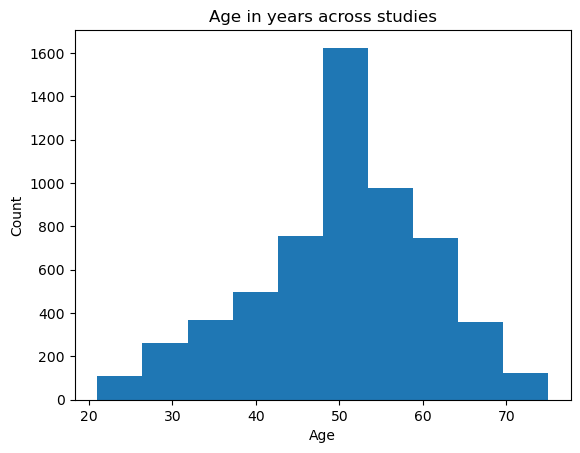

In [11]:
# beginning EDA 
# Starting with continuous variables however, there is not much for continuous thus doing a few age plots

Age = np.floor(sev.Age)


plt.hist(Age, bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age in years across studies');

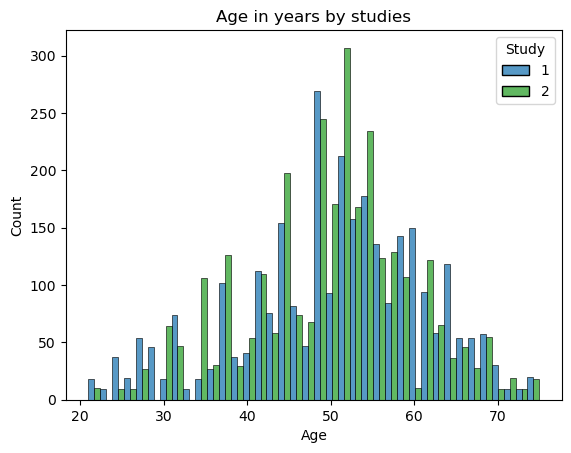

In [12]:
palette = ['tab:blue', 'tab:green']

sns.histplot(data=sev, x="Age", hue="Study", multiple="dodge", palette=palette,);
plt.title('Age in years by studies');

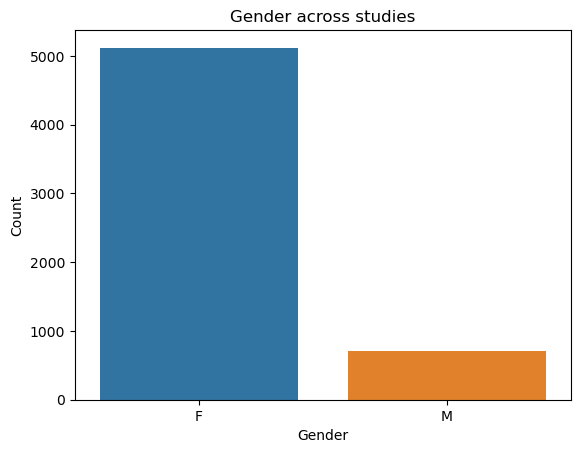

In [13]:
# beginning categorical variables for gender
# 
sns.countplot(x=sev["Sex"]);
plt.title('Gender across studies');
plt.xlabel('Gender')
plt.ylabel ("Count");


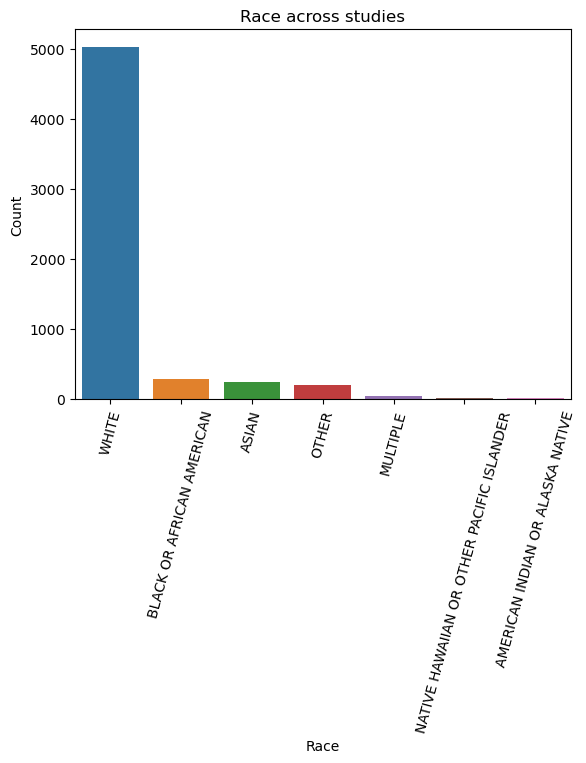

In [14]:
# beginning categorical variables for race 
# 
sns.countplot(x=sev["Race"]);
plt.title('Race across studies');
plt.xlabel('Race')
plt.ylabel ("Count");
plt.xticks(rotation=75, ha='center');



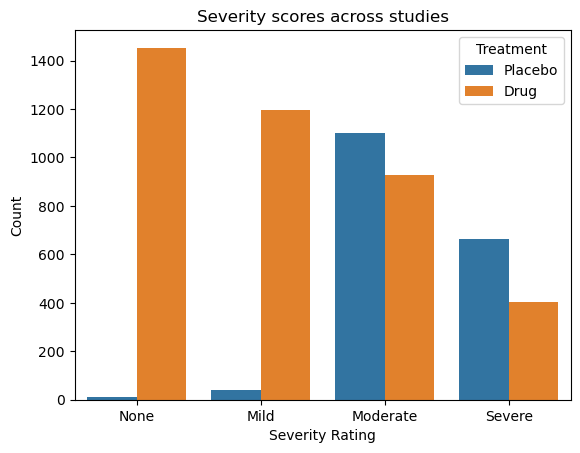

In [15]:
# beginning categorical variables for the severity data 
# 
sns.countplot(x=sev["ScaleScore"], hue=sev["Treat"]);
plt.title('Severity scores across studies');
plt.xlabel('Severity Rating')
plt.ylabel ("Count");
plt.xticks([0, 1, 2, 3], ['None', 'Mild', 'Moderate', 'Severe']);
plt.legend(title='Treatment', loc='upper right', labels=['Placebo', 'Drug']);


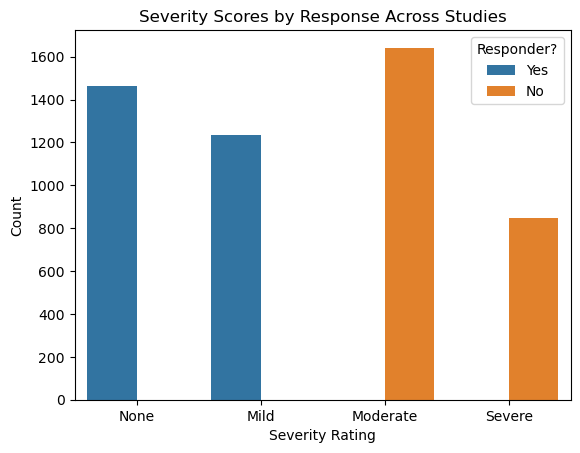

In [16]:
# It is expected that if you have a response, you would be a 0 or 1, this is more confirmatory

sns.countplot(data=sev, x="ScaleScore", hue="Had_response_YN")
plt.title('Severity Scores by Response Across Studies');
plt.xlabel('Severity Rating')
plt.ylabel ("Count");
plt.xticks([0, 1, 2, 3], ['None', 'Mild', 'Moderate', 'Severe']);
plt.legend(title='Responder?', loc='upper right', labels=['Yes', 'No']);

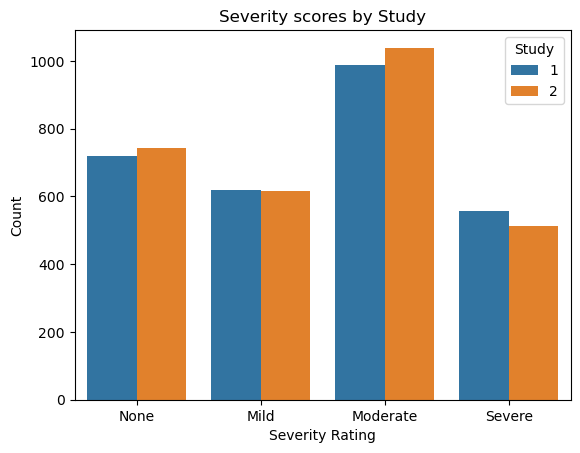

In [17]:
# showing no large differences across studies in terms of severity rating spread

sns.countplot(x=sev["ScaleScore"], hue=sev["Study"]);
plt.title('Severity scores by Study');
plt.xlabel('Severity Rating')
plt.ylabel ("Count");
plt.xticks([0, 1, 2, 3], ['None', 'Mild', 'Moderate', 'Severe']);

In [18]:
agg_sev = sev.groupby(['Visit_Wk', 'ScaleScore'])['Study'].sum().unstack().fillna(0)
agg_sev

ScaleScore,0.0,1.0,2.0,3.0
Visit_Wk,,,,
0,0.0,0.0,581.0,334.0
1,438.0,146.0,220.0,106.0
2,490.0,106.0,212.0,102.0
4,497.0,110.0,195.0,108.0
8,382.0,202.0,202.0,124.0
12,207.0,331.0,243.0,129.0
16,109.0,348.0,310.0,143.0
20,51.0,287.0,391.0,181.0
24,25.0,172.0,468.0,245.0


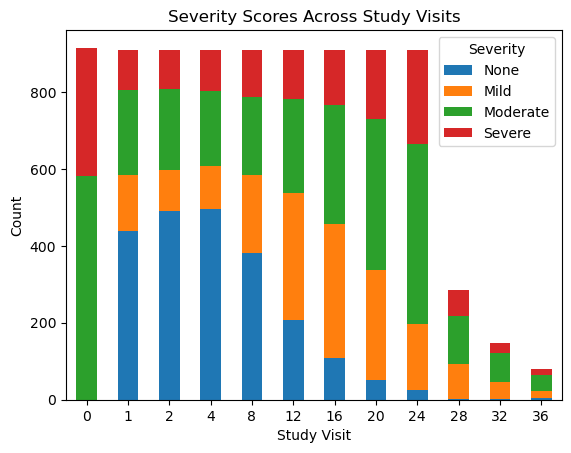

In [19]:
agg_sev.plot(kind='bar', stacked=True);

plt.title('Severity Scores Across Study Visits');
plt.xlabel('Study Visit')
plt.ylabel ("Count");
plt.xticks(rotation=0, ha='center');
plt.legend(title='Severity', loc='upper right', labels=['None', 'Mild', 'Moderate', 'Severe']);


In [20]:
# separating out treated from placebo, 1 is placebo and 2 is treated  
filt = (sev['Treat'] == 1)



In [21]:
sevt = sev.loc[~filt]
sevt

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Treatment Day 0,0,2.0,NaN
1,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 1,1,0.0,Y
2,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 2,2,0.0,Y
3,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 4,4,0.0,Y
4,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 8,8,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 8,8,0.0,Y
5824,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 12,12,0.0,Y
5825,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 16,16,0.0,Y
5826,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 20,20,0.0,Y


In [22]:
agg_sevt = sevt.groupby(['Visit_Wk', 'ScaleScore'])['Study'].sum().unstack().fillna(0)
agg_sevt

ScaleScore,0.0,1.0,2.0,3.0
Visit_Wk,,,,
0,0.0,0.0,381.0,230.0
1,438.0,139.0,22.0,11.0
2,489.0,101.0,18.0,2.0
4,493.0,103.0,12.0,2.0
8,379.0,193.0,29.0,9.0
12,206.0,325.0,67.0,12.0
16,108.0,339.0,136.0,27.0
20,48.0,283.0,219.0,60.0
24,24.0,167.0,289.0,130.0


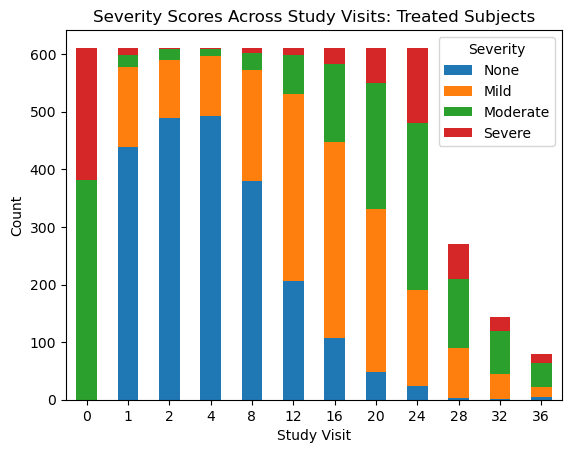

In [23]:
agg_sevt.plot(kind='bar', stacked=True);

plt.title('Severity Scores Across Study Visits: Treated Subjects');
plt.xlabel('Study Visit')
plt.ylabel ("Count");
plt.xticks(rotation=0, ha='center');
plt.legend(title='Severity', loc='upper right', labels=['None', 'Mild', 'Moderate', 'Severe']);

In [24]:
sevp = sev.loc[filt]
sevp

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN
12,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Treatment Day 0,0,2.0,NaN
13,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 1,1,2.0,N
14,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 2,2,2.0,N
15,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 4,4,2.0,N
16,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 8,8,2.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5814,2,215,USA,WA,Spokane,99202,215-001,40,F,WHITE,1,Week 8,8,3.0,N
5815,2,215,USA,WA,Spokane,99202,215-001,40,F,WHITE,1,Week 12,12,3.0,N
5816,2,215,USA,WA,Spokane,99202,215-001,40,F,WHITE,1,Week 16,16,3.0,N
5817,2,215,USA,WA,Spokane,99202,215-001,40,F,WHITE,1,Week 20,20,3.0,N


In [25]:
agg_sevp = sevp.groupby(['Visit_Wk', 'ScaleScore'])['Study'].sum().unstack().fillna(0)
agg_sevp

ScaleScore,0.0,1.0,2.0,3.0
Visit_Wk,,,,
0,0.0,0.0,200.0,104.0
1,0.0,7.0,198.0,95.0
2,1.0,5.0,194.0,100.0
4,4.0,7.0,183.0,106.0
8,3.0,9.0,173.0,115.0
12,1.0,6.0,176.0,117.0
16,1.0,9.0,174.0,116.0
20,3.0,4.0,172.0,121.0
24,1.0,5.0,179.0,115.0


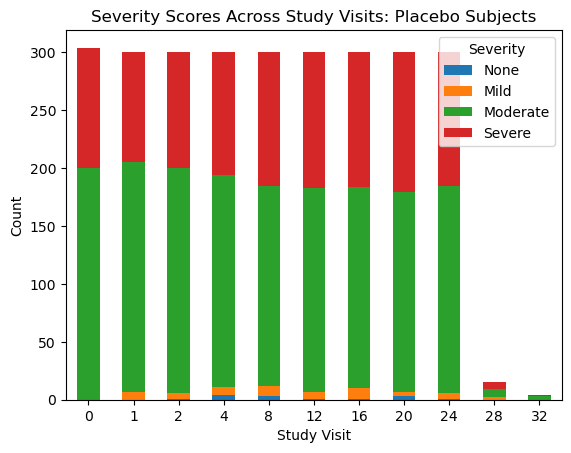

In [26]:
agg_sevp.plot(kind='bar', stacked=True);

plt.title('Severity Scores Across Study Visits: Placebo Subjects');
plt.xlabel('Study Visit')
plt.ylabel ("Count");
plt.xticks(rotation=0, ha='center');
plt.legend(title='Severity', loc='upper right', labels=['None', 'Mild', 'Moderate', 'Severe']);

In [27]:
# looking at results by site
agg_sevi = sev.groupby(['SiteID', 'ScaleScore'])['Study'].sum().unstack().fillna(0)
agg_sevi

ScaleScore,0.0,1.0,2.0,3.0
SiteID,,,,
101,54.0,28.0,56.0,2.0
102,61.0,50.0,72.0,17.0
103,69.0,20.0,54.0,39.0
104,59.0,36.0,84.0,2.0
105,23.0,29.0,66.0,39.0
106,2.0,23.0,35.0,12.0
107,41.0,28.0,24.0,72.0
108,42.0,45.0,25.0,80.0
109,75.0,77.0,122.0,46.0


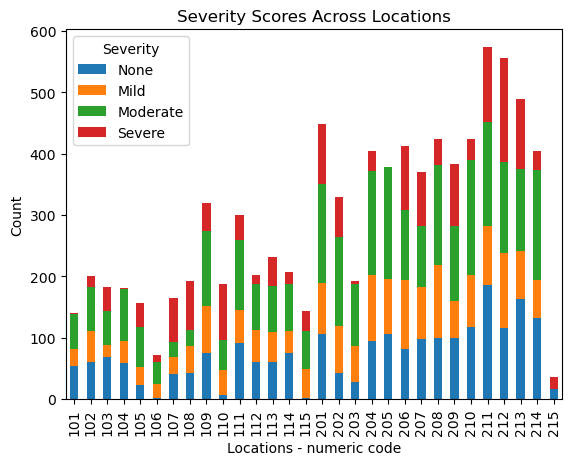

In [28]:
agg_sevi.plot(kind='bar', stacked=True);

plt.title('Severity Scores Across Locations');
plt.xlabel('Locations - numeric code')
plt.ylabel ("Count");
plt.legend(title='Severity', loc='upper left', labels=['None', 'Mild', 'Moderate', 'Severe']);

In [29]:
agg_sevpi = sevp.groupby(['SiteID', 'ScaleScore'])['Study'].sum().unstack().fillna(0)
agg_sevpi

ScaleScore,0.0,1.0,2.0,3.0
SiteID,,,,
101,0.0,0.0,35.0,1.0
102,0.0,16.0,41.0,6.0
103,5.0,0.0,32.0,18.0
104,0.0,0.0,54.0,0.0
105,0.0,0.0,30.0,27.0
106,0.0,0.0,19.0,8.0
107,1.0,0.0,0.0,53.0
108,1.0,1.0,6.0,55.0
109,0.0,2.0,68.0,30.0


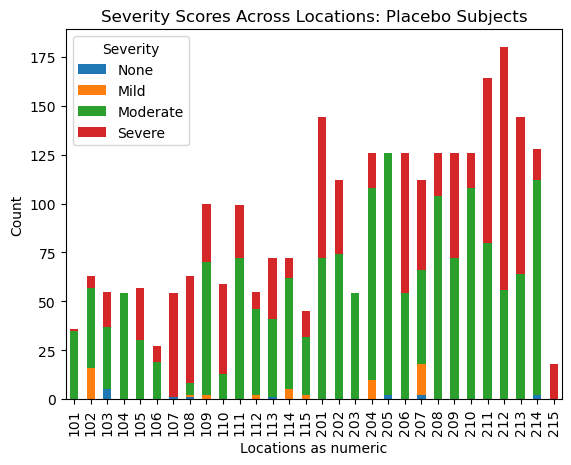

In [30]:
agg_sevpi.plot(kind='bar', stacked=True);

plt.title('Severity Scores Across Locations: Placebo Subjects');
plt.xlabel('Locations as numeric')
plt.ylabel ("Count");
plt.legend(title='Severity', loc='upper left', labels=['None', 'Mild', 'Moderate', 'Severe']);

In [31]:
agg_sevti = sevt.groupby(['SiteID', 'ScaleScore'])['Study'].sum().unstack().fillna(0)
agg_sevti

ScaleScore,0.0,1.0,2.0,3.0
SiteID,,,,
101,54.0,28.0,21.0,1.0
102,61.0,34.0,31.0,11.0
103,64.0,20.0,22.0,21.0
104,59.0,36.0,30.0,2.0
105,23.0,29.0,36.0,12.0
106,2.0,23.0,16.0,4.0
107,40.0,28.0,24.0,19.0
108,41.0,44.0,19.0,25.0
109,75.0,75.0,54.0,16.0


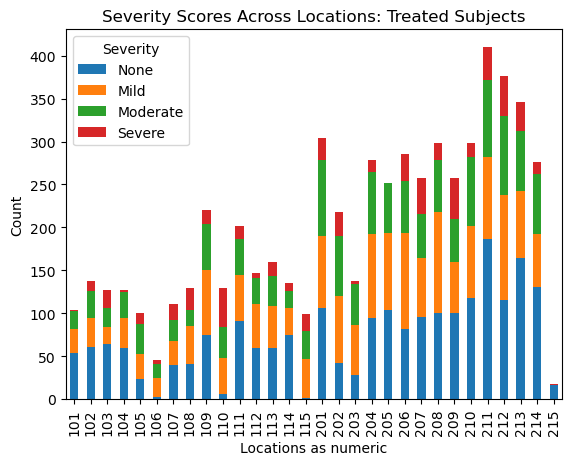

In [32]:
agg_sevti.plot(kind='bar', stacked=True);

plt.title('Severity Scores Across Locations: Treated Subjects');
plt.xlabel('Locations as numeric')
plt.ylabel ("Count");
plt.legend(title='Severity', loc='upper left', labels=['None', 'Mild', 'Moderate', 'Severe']);

In [33]:
# removing scores of 0 for plotting 
filt = (gt['Score'] > 0)

In [34]:
gt2 = gt.loc[filt]
gt2

,Country,Region_MetroArea,Score
0,US,Florence-Myrtle Beach SC,100.0
1,US,Palm Springs CA,90.0
2,US,West Palm Beach-Ft. Pierce FL,89.0
3,US,Tampa-St. Petersburg (Sarasota) FL,82.0
4,US,Ft. Myers-Naples FL,79.0
...,...,...,...
94,US,Cedar Rapids-Waterloo-Iowa City & Dubuque IA,22.0
210,CA,British Columbia,100.0
211,CA,Ontario,89.0
212,CA,Alberta,48.0


In [35]:
# ah this took a moment - I can sort but then index doesn't change but now with reset it can 
gt3 = gt2.sort_values(by=['Score'], ascending=False).reset_index(drop=True)
gt3

,Country,Region_MetroArea,Score
0,US,Florence-Myrtle Beach SC,100.0
1,CA,British Columbia,100.0
2,US,Palm Springs CA,90.0
3,US,West Palm Beach-Ft. Pierce FL,89.0
4,CA,Ontario,89.0
...,...,...,...
94,US,Roanoke-Lynchburg VA,27.0
95,US,Des Moines-Ames IA,26.0
96,US,Omaha NE,25.0
97,US,Cedar Rapids-Waterloo-Iowa City & Dubuque IA,22.0


Text(0.5, 1.0, 'Histogram of Score')

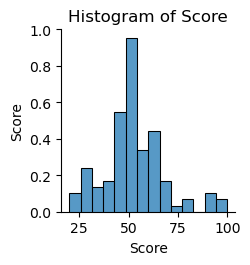

In [36]:
# taking a look at the google trends data 
# simple visualization of numerics 

sns.pairplot(gt3);
plt.title ("Histogram of Score")

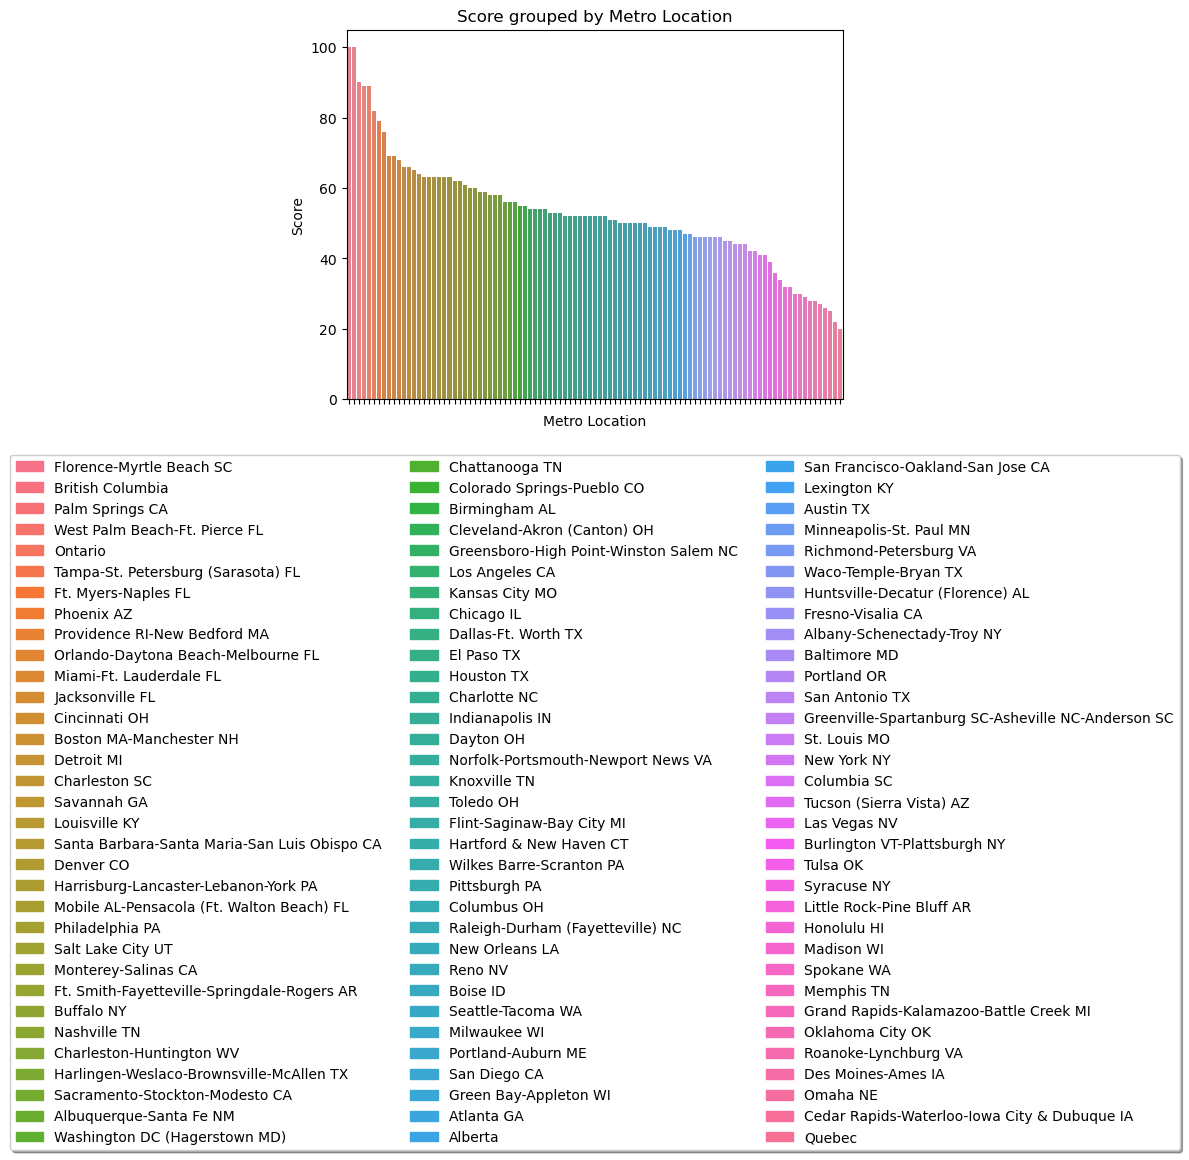

In [37]:
# this solution took a long time for me and it is still 'not perfect' but better and more readable 
# this is a solution that I modified from a few different posts I found - I understood that a legend for x was better than 
# displaying category names on the x axis but I did not know how to do that 
# Using the index and then labeling the index is good, I am still thinking about this solution  

from matplotlib.patches import Patch

colors = sns.color_palette('husl', n_colors=len(gt3))
p = sns.barplot(x=gt3.index, y='Score', data=gt3, palette=colors) # hue='Region_MetroArea')
p.set_xticklabels('');

# create color map with colors and gt3 metro 
cmap = dict(zip(gt3.Region_MetroArea, colors))

# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]

# add the legend
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3 , borderaxespad=0);
plt.title ("Score grouped by Metro Location")
plt.xlabel ("Metro Location");

### EDA Conclusions

The results of the exploratory data analysis show that for demographics, there are more females than males in these two studies as well as most subjects are Caucasian and tend to be between the ages of 40 to 60 years of age. These studies were not balanced for these demographics and all subjects meet the age requirements to participate in these studies. The wrinkle scale shows that overall, the placebo and drug groups move in opposite directions on the scale which is expected if the drug is efficacious. Likewise, the rating scales are similarly distributed between the two studies which are done in different locations of the United States and Canada. Further examination of the severity data show that across visits, severity increases overall, likewise, one can determine that as the study visits increase, the study population is decreasing as subjects leave the studies. When split by treatment, the severity ratings show that the subjects who received drug perform better on the severity scale though treatment does wear off. When examining placebo for severity ratings over time, this group did not perform well.  When looking at the data by location, severity ratings show similar differences for placebo versus drug. In terms of site differences, one can see that for each treatment group – there are differences between the locations. For the Google Trends data, the first histogram shows most scores to be around 40-60 while the last plot displays the count for each metro area. 

This preliminary analysis indicates that for severity scores and interested in getting treatment, there are differences between locations. Further analyses need to be conducted in order to better understand these potential differences and relationships.


### Starting Milestone 2  

- Drop any features that are not useful for your model building and explain why they are not useful.
- Perform any data extraction/selection steps.
- Transform features if necessary.
- Engineer new useful features.
- Deal with missing data (do not just drop rows or columns without justifying this).
- Create dummy variables if necessary.

My first step will be to do some clean up work & new features for the severity data, the google trends data and then to merge the three datasets together 

In [38]:
# I am doing some work for the severity data prior to creating the final dataset 

# making the target variable a numeric 1 for yes, 0 for no for the severity data 
sev['Had_response_YN'] = (sev['Had_response_YN']=='Y').astype(int) 
sev

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Treatment Day 0,0,2.0,0
1,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 1,1,0.0,1
2,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 2,2,0.0,1
3,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 4,4,0.0,1
4,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 8,8,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 8,8,0.0,1
5824,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 12,12,0.0,1
5825,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 16,16,0.0,1
5826,2,215,USA,WA,Spokane,99202,215-003,45,F,WHITE,2,Week 20,20,0.0,1


In [39]:
# filtering out baseline records & Week 28, 32, 36 
# as these are not needed - I am only interested in post baseline results up to Week 24

# separating out visits  
filt2 = (sev['Visit'] == "Treatment Day 0")|(sev['Visit'] == "Week 28")|(sev['Visit'] == "Week 32")|(sev['Visit'] == "Week 36")

In [40]:
sev2 = sev.loc[~filt2]
print(sev2.to_string())

      Study  SiteID Country    State               City Postal Code       ID  Age Sex                                       Race  Treat    Visit  Visit_Wk  ScaleScore  Had_response_YN
1         1     101     USA       TN          Nashville       37203  101-001   52   F                                      WHITE      2   Week 1         1         0.0                1
2         1     101     USA       TN          Nashville       37203  101-001   52   F                                      WHITE      2   Week 2         2         0.0                1
3         1     101     USA       TN          Nashville       37203  101-001   52   F                                      WHITE      2   Week 4         4         0.0                1
4         1     101     USA       TN          Nashville       37203  101-001   52   F                                      WHITE      2   Week 8         8         0.0                1
5         1     101     USA       TN          Nashville       37203  101-001   5

In [41]:
# more process for the severity dataframe - age groups & Had_response_YN composite across remaining study visits 
# creating a composite for Had_response_YN

# I am picking the mean to create the composite response because 
composite_resp = pd.DataFrame(sev2.groupby(['ID'])['Had_response_YN'].mean()).rename(columns = {"Had_response_YN": "Comp_Score"})
composite_resp


,Comp_Score
ID,
101-001,1.000
101-002,0.000
101-004,0.000
101-005,1.000
101-007,0.875
...,...
214-019,0.750
214-020,1.000
214-021,0.750


In [42]:
# looking at these values - I am realizing that this composite is tricky - if Week 24 has a rating of 0 then I assume
# the subject is returning to baseline and their composite should be 0 - so I will add a condition to the composite that
# week 24 must be 1 as well as composite > 0 

# Since I now have a composite - I will go ahead and now only keep Week 24 
filt3 = (sev2['Visit'] == "Week 24")

In [43]:
# keeping only week 24
sev3 = sev2.loc[filt3]
sev3.head(10)

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN
8,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 24,24,1.0,1
20,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 24,24,2.0,0
29,1,101,USA,TN,Nashville,37203,101-004,30,F,WHITE,1,Week 24,24,2.0,0
38,1,101,USA,TN,Nashville,37203,101-005,60,F,WHITE,2,Week 24,24,1.0,1
48,1,101,USA,TN,Nashville,37203,101-007,45,F,WHITE,2,Week 24,24,1.0,1
60,1,101,USA,TN,Nashville,37203,101-008,44,F,WHITE,2,Week 24,24,1.0,1
72,1,101,USA,TN,Nashville,37203,101-009,49,F,WHITE,2,Week 24,24,0.0,1
84,1,101,USA,TN,Nashville,37203,101-010,54,F,BLACK OR AFRICAN AMERICAN,1,Week 24,24,2.0,0
93,1,101,USA,TN,Nashville,37203,101-011,57,F,WHITE,1,Week 24,24,2.0,0
102,1,101,USA,TN,Nashville,37203,101-012,60,F,WHITE,2,Week 24,24,1.0,1


In [44]:
# merge composite back onto the dataframe 

sev4 = pd.merge(sev3, composite_resp, how = "inner", on="ID" )
sev4.head(4)

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN,Comp_Score
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 24,24,1.0,1,1.0
1,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 24,24,2.0,0,0.0
2,1,101,USA,TN,Nashville,37203,101-004,30,F,WHITE,1,Week 24,24,2.0,0,0.0
3,1,101,USA,TN,Nashville,37203,101-005,60,F,WHITE,2,Week 24,24,1.0,1,1.0


In [45]:
# I don't think I like this way to create this column but I have spent too much time on it and this works
# complete the derivation for the target variable 

sev4.loc[(sev4["Comp_Score"] == 1), 'Target'] = 1 
sev4.loc[(sev4["Comp_Score"] == 0), 'Target'] = 0 
sev4.loc[((sev4["Comp_Score"] < 1) & (sev4["Comp_Score"] > 0)) & (sev4["ScaleScore"] < 2.0), 'Target'] = 1 
sev4.loc[((sev4["Comp_Score"] < 1) & (sev4["Comp_Score"] > 0)) & (sev4["ScaleScore"] >= 2.0), 'Target'] = 0 

sev4

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN,Comp_Score,Target
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
1,1,101,USA,TN,Nashville,37203,101-002,43,F,WHITE,1,Week 24,24,2.0,0,0.000,0.0
2,1,101,USA,TN,Nashville,37203,101-004,30,F,WHITE,1,Week 24,24,2.0,0,0.000,0.0
3,1,101,USA,TN,Nashville,37203,101-005,60,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
4,1,101,USA,TN,Nashville,37203,101-007,45,F,WHITE,2,Week 24,24,1.0,1,0.875,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,2,214,Canada,QC,Montreal,H3Z 1B7,214-019,62,F,WHITE,2,Week 24,24,2.0,0,0.750,0.0
605,2,214,Canada,QC,Montreal,H3Z 1B7,214-020,57,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
606,2,214,Canada,QC,Montreal,H3Z 1B7,214-021,47,F,WHITE,2,Week 24,24,2.0,0,0.750,0.0
607,2,215,USA,WA,Spokane,99202,215-001,40,F,WHITE,1,Week 24,24,3.0,0,0.000,0.0


In [46]:
# checking to make sure that there are only 0,1. I did an outside check to see that at Week 24, the results were same & they are
sev4.groupby(['Treat','Target'])['Target'].count()

Treat  Target
1      0.0       199
       1.0         4
2      0.0       275
       1.0       131
Name: Target, dtype: int64

In [47]:
# recoding a few of the placebos to treated because they have a response and that is not possible unless you received drug

sev4.loc[((sev4["Treat"] == 1) & (sev4["Target"] == 1)), 'Treat'] = 2 

In [48]:
# check again 
sev4.groupby(['Treat','Target'])['Target'].count()

Treat  Target
1      0.0       199
2      0.0       275
       1.0       135
Name: Target, dtype: int64

In [49]:
# In order to perform a relevant analysis - those subjects who received placebo have to be removed. In real life
# When you go to get treated, you receive drug so I have to take out these subjects otherwise they will bias the analysis 

# looking at the above frequency count reminded me of this, 2 is treated  
filt4 = (sev4['Treat'] == 2)
sev4 = sev4.loc[filt4]
sev4.head(10)

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN,Comp_Score,Target
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
3,1,101,USA,TN,Nashville,37203,101-005,60,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
4,1,101,USA,TN,Nashville,37203,101-007,45,F,WHITE,2,Week 24,24,1.0,1,0.875,1.0
5,1,101,USA,TN,Nashville,37203,101-008,44,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
6,1,101,USA,TN,Nashville,37203,101-009,49,F,WHITE,2,Week 24,24,0.0,1,1.000,1.0
9,1,101,USA,TN,Nashville,37203,101-012,60,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
10,1,101,USA,TN,Nashville,37203,101-013,45,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
11,1,101,USA,TN,Nashville,37203,101-014,59,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
12,1,101,USA,TN,Nashville,37203,101-015,52,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0
13,1,102,USA,CO,Greenwood Village,80111,102-001,45,F,WHITE,2,Week 24,24,2.0,0,0.625,0.0


In [50]:
dataTypeSeries = sev4.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries.to_string())

Data type of each column of Dataframe :
Study                int64
SiteID               int64
Country             object
State               object
City                object
Postal Code         object
ID                  object
Age                  int64
Sex                 object
Race                object
Treat                int64
Visit               object
Visit_Wk             int64
ScaleScore         float64
Had_response_YN      int32
Comp_Score         float64
Target             float64


In [51]:
def agefun (age, high, low):
    if age > high:
        return(">65")
    if age > low:
        return(">40-65")
    return("18-40")

In [52]:
# creating age categories - I am sure there is a better method but I kept getting errors so I did this

newcol = sev4["Age"].apply(agefun, args=[65, 40])

In [53]:
sev4 = sev4.assign(AgeCat=newcol)
sev4.head(5)

,Study,SiteID,Country,State,City,Postal Code,ID,Age,Sex,Race,Treat,Visit,Visit_Wk,ScaleScore,Had_response_YN,Comp_Score,Target,AgeCat
0,1,101,USA,TN,Nashville,37203,101-001,52,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0,>40-65
3,1,101,USA,TN,Nashville,37203,101-005,60,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0,>40-65
4,1,101,USA,TN,Nashville,37203,101-007,45,F,WHITE,2,Week 24,24,1.0,1,0.875,1.0,>40-65
5,1,101,USA,TN,Nashville,37203,101-008,44,F,WHITE,2,Week 24,24,1.0,1,1.000,1.0,>40-65
6,1,101,USA,TN,Nashville,37203,101-009,49,F,WHITE,2,Week 24,24,0.0,1,1.000,1.0,>40-65


In [54]:
# dropping column from the severity dataset 

sev4.drop(['Age','Race','Visit', 'Visit_Wk', 'ScaleScore', "Had_response_YN", "Comp_Score", 'Treat'], axis=1, inplace=True)
sev4

,Study,SiteID,Country,State,City,Postal Code,ID,Sex,Target,AgeCat
0,1,101,USA,TN,Nashville,37203,101-001,F,1.0,>40-65
3,1,101,USA,TN,Nashville,37203,101-005,F,1.0,>40-65
4,1,101,USA,TN,Nashville,37203,101-007,F,1.0,>40-65
5,1,101,USA,TN,Nashville,37203,101-008,F,1.0,>40-65
6,1,101,USA,TN,Nashville,37203,101-009,F,1.0,>40-65
...,...,...,...,...,...,...,...,...,...,...
603,2,214,Canada,QC,Montreal,H3Z 1B7,214-018,F,0.0,>40-65
604,2,214,Canada,QC,Montreal,H3Z 1B7,214-019,F,0.0,>40-65
605,2,214,Canada,QC,Montreal,H3Z 1B7,214-020,F,1.0,>40-65
606,2,214,Canada,QC,Montreal,H3Z 1B7,214-021,F,0.0,>40-65


In [55]:
# reordering
sev5 = sev4[['Target', 'Study', 'SiteID', 'ID', 'Sex', 'AgeCat', 'Country', 'State', 'City', 'Postal Code']]
sev5

,Target,Study,SiteID,ID,Sex,AgeCat,Country,State,City,Postal Code
0,1.0,1,101,101-001,F,>40-65,USA,TN,Nashville,37203
3,1.0,1,101,101-005,F,>40-65,USA,TN,Nashville,37203
4,1.0,1,101,101-007,F,>40-65,USA,TN,Nashville,37203
5,1.0,1,101,101-008,F,>40-65,USA,TN,Nashville,37203
6,1.0,1,101,101-009,F,>40-65,USA,TN,Nashville,37203
...,...,...,...,...,...,...,...,...,...,...
603,0.0,2,214,214-018,F,>40-65,Canada,QC,Montreal,H3Z 1B7
604,0.0,2,214,214-019,F,>40-65,Canada,QC,Montreal,H3Z 1B7
605,1.0,2,214,214-020,F,>40-65,Canada,QC,Montreal,H3Z 1B7
606,0.0,2,214,214-021,F,>40-65,Canada,QC,Montreal,H3Z 1B7


In [56]:
sev5 = sev5.reset_index(drop=True)
sev5

,Target,Study,SiteID,ID,Sex,AgeCat,Country,State,City,Postal Code
0,1.0,1,101,101-001,F,>40-65,USA,TN,Nashville,37203
1,1.0,1,101,101-005,F,>40-65,USA,TN,Nashville,37203
2,1.0,1,101,101-007,F,>40-65,USA,TN,Nashville,37203
3,1.0,1,101,101-008,F,>40-65,USA,TN,Nashville,37203
4,1.0,1,101,101-009,F,>40-65,USA,TN,Nashville,37203
...,...,...,...,...,...,...,...,...,...,...
405,0.0,2,214,214-018,F,>40-65,Canada,QC,Montreal,H3Z 1B7
406,0.0,2,214,214-019,F,>40-65,Canada,QC,Montreal,H3Z 1B7
407,1.0,2,214,214-020,F,>40-65,Canada,QC,Montreal,H3Z 1B7
408,0.0,2,214,214-021,F,>40-65,Canada,QC,Montreal,H3Z 1B7


The columns that I am dropping from the Severity dataframe are: Age, Treat, Race, Visit, Visit_Wk, ScaleScore, Had_response_YN, Comp_Score. These columns are being dropped because for Age - I created a grouped column to be used in analysis, Race because the bar chart of this demographic showed that the population is mostly White thus we cannot have relevent subgroup analyses until data collection uses a more balanced approach. For Visit, Visit_Wk and ScaleScore are dropped as they are not needed now that the data frame is trimmed as well as Had_response_YN and Comp_Score as these variables helped to create Target. Lastly, I dropped Treat because it was only the subjects treated with drug. 

In [57]:
# need to fix country prior to merge in google data 
country_mapping = {'CA':'Canada'
                    ,'US':'USA'
                  }

In [58]:
gt = gt.assign(Country  = gt.Country.map(country_mapping))

In [59]:
gt

,Country,Region_MetroArea,Score
0,USA,Florence-Myrtle Beach SC,100.0
1,USA,Palm Springs CA,90.0
2,USA,West Palm Beach-Ft. Pierce FL,89.0
3,USA,Tampa-St. Petersburg (Sarasota) FL,82.0
4,USA,Ft. Myers-Naples FL,79.0
...,...,...,...
218,Canada,Saskatchewan,NaN
219,Canada,Northwest Territories,NaN
220,Canada,Nunavut,NaN
221,Canada,Prince Edward Island,NaN


In [60]:
# merging datasources for metro and google trends data

# oh duh I just flipped the order to gt and metro to get a clean merge - okay ! 

gtmet = pd.merge(metro, gt, how="left", on=["Region_MetroArea"])
print(gtmet.to_string())

   Country_x    State               City Postal Code                        Region_MetroArea Country_y  Score
0        USA       TN          Nashville       37203                            Nashville TN       USA   59.0
1        USA       CO  Greenwood Village       80111                               Denver CO       USA   63.0
2        USA       NC        Chapel Hill       27517        Raleigh-Durham (Fayetteville) NC       USA   50.0
3        USA       MA      Chestnut Hill        2467                 Boston MA-Manchester NH       USA   65.0
4        USA       NJ         Montclaire        7042                             New York NY       USA   42.0
5        USA       NY           New York       10001                             New York NY       USA   42.0
6        USA       FL         Boca Raton       33431                 Miami-Ft. Lauderdale FL       USA   68.0
7        USA       CA      San Francisco       94117       San Francisco-Oakland-San Jose CA       USA   48.0
8        U

In [61]:
gtmet.shape

(29, 7)

Dropping missing data - the google trends data has many cities in the US while the Severity studies were conducted in specific locations in the United States and Canada. I decided to fix my merge to frame to the metro data thus leaving out records where google trends did not have a matching city. At this stage, this is the best choice.

Eventually, it would great to find a way to create a similarity score for cities/metro areas where I could predict those cities or metro areas severity treatment performance. For this project, I am going to bring in the google trend data and match merge to the severity data on Country, State, City. 

In [62]:
# checking to confirm no missing
gtmet = gtmet.dropna(subset='State')

In [63]:
gtmet.head(5)

,Country_x,State,City,Postal Code,Region_MetroArea,Country_y,Score
0,USA,TN,Nashville,37203,Nashville TN,USA,59.0
1,USA,CO,Greenwood Village,80111,Denver CO,USA,63.0
2,USA,NC,Chapel Hill,27517,Raleigh-Durham (Fayetteville) NC,USA,50.0
3,USA,MA,Chestnut Hill,2467,Boston MA-Manchester NH,USA,65.0
4,USA,NJ,Montclaire,7042,New York NY,USA,42.0


In [64]:
gtmet.shape

(29, 7)

In [65]:
# check for duplicates - no dups 
duplicate = gtmet[gtmet.duplicated(keep = 'last')]
 
print("Duplicate Rows :", duplicate)

Duplicate Rows : Empty DataFrame
Columns: [Country_x, State, City, Postal Code, Region_MetroArea, Country_y, Score]
Index: []


In [66]:
# rename country 
nameDict={"Country_y":"Country"}
gtmet=gtmet.rename(columns=nameDict)

In [67]:
gtmet.head(1)

,Country_x,State,City,Postal Code,Region_MetroArea,Country,Score
0,USA,TN,Nashville,37203,Nashville TN,USA,59.0


In [68]:
# dropping Country_x
gtmet.drop(['Country_x', 'Postal Code'], axis=1, inplace=True)
gtmet

,State,City,Region_MetroArea,Country,Score
0,TN,Nashville,Nashville TN,USA,59.0
1,CO,Greenwood Village,Denver CO,USA,63.0
2,NC,Chapel Hill,Raleigh-Durham (Fayetteville) NC,USA,50.0
3,MA,Chestnut Hill,Boston MA-Manchester NH,USA,65.0
4,NJ,Montclaire,New York NY,USA,42.0
5,NY,New York,New York NY,USA,42.0
6,FL,Boca Raton,Miami-Ft. Lauderdale FL,USA,68.0
7,CA,San Francisco,San Francisco-Oakland-San Jose CA,USA,48.0
8,CA,Beverly Hills,Los Angeles CA,USA,54.0
9,NY,New York,New York NY,USA,42.0


In [69]:
# same check for severity 
duplicate2 = sev5[sev5.duplicated(keep = 'last')]
 
print("Duplicate Rows :", duplicate2)

Duplicate Rows : Empty DataFrame
Columns: [Target, Study, SiteID, ID, Sex, AgeCat, Country, State, City, Postal Code]
Index: []


In [70]:
##### one dataset
sevmet = pd.merge(sev5, gtmet, how="left", on=["Country", 'State', 'City'])
sevmet

,Target,Study,SiteID,ID,Sex,AgeCat,Country,State,City,Postal Code,Region_MetroArea,Score
0,1.0,1,101,101-001,F,>40-65,USA,TN,Nashville,37203,Nashville TN,59.0
1,1.0,1,101,101-005,F,>40-65,USA,TN,Nashville,37203,Nashville TN,59.0
2,1.0,1,101,101-007,F,>40-65,USA,TN,Nashville,37203,Nashville TN,59.0
3,1.0,1,101,101-008,F,>40-65,USA,TN,Nashville,37203,Nashville TN,59.0
4,1.0,1,101,101-009,F,>40-65,USA,TN,Nashville,37203,Nashville TN,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.0,2,214,214-018,F,>40-65,Canada,QC,Montreal,H3Z 1B7,Quebec,20.0
424,0.0,2,214,214-019,F,>40-65,Canada,QC,Montreal,H3Z 1B7,Quebec,20.0
425,1.0,2,214,214-020,F,>40-65,Canada,QC,Montreal,H3Z 1B7,Quebec,20.0
426,0.0,2,214,214-021,F,>40-65,Canada,QC,Montreal,H3Z 1B7,Quebec,20.0


In [71]:
# something seems off with the merge - now I have more rows than I would have expected

# after merging there are duplicates 
duplicate3 = sevmet[sevmet.duplicated(keep = 'last')]
 
print("Duplicate Rows :", duplicate3)

Duplicate Rows :      Target  Study  SiteID       ID Sex  AgeCat Country State      City  \
62      0.0      1     106  106-002   M  >40-65     USA    NY  New York   
64      0.0      1     106  106-005   M  >40-65     USA    NY  New York   
66      0.0      1     106  106-008   F   18-40     USA    NY  New York   
68      0.0      1     106  106-015   M   18-40     USA    NY  New York   
70      0.0      1     106  106-016   F  >40-65     USA    NY  New York   
120     0.0      1     110  110-002   F  >40-65     USA    NY  New York   
122     0.0      1     110  110-004   F   18-40     USA    NY  New York   
124     0.0      1     110  110-006   F  >40-65     USA    NY  New York   
126     0.0      1     110  110-009   F  >40-65     USA    NY  New York   
128     0.0      1     110  110-011   F     >65     USA    NY  New York   
130     0.0      1     110  110-013   F  >40-65     USA    NY  New York   
132     0.0      1     110  110-015   F     >65     USA    NY  New York   
134     

In [72]:
# are there any missing values? 
for c in sevmet: 
    miss = sevmet[c].isnull().sum()
    dd = 0
    if miss > 0: 
        print("{} has {} missing values(s)".format(c,miss))
    else:
        print("{} has no missing values".format(c))

Target has no missing values
Study has no missing values
SiteID has no missing values
ID has no missing values
Sex has no missing values
AgeCat has no missing values
Country has no missing values
State has no missing values
City has no missing values
Postal Code has no missing values
Region_MetroArea has no missing values
Score has no missing values


In [73]:
# still investigating merge issue 

sevmet.groupby(['City','Postal Code'])['Postal Code'].count()

City               Postal Code
Beverly Hills      90210          23
Birmingham         35025          14
                   48009          11
Boca Raton         33431          12
Burlington         L7N 3N2        15
Chapel Hill        27517          14
Chestnut Hill      2467           13
Coral Gables       33146          20
Encinitas          92024          19
Greenwood Village  80111          15
High Point         27262          14
Los Angeles        90069          15
Montclaire         7042           11
Montreal           H3Z 1B7        14
Naperville         60563          12
Nashville          37203           9
New Orleans        70124          14
New York           10001          10
                   10022          26
Newport Beach      92663          14
Omaha              68144          20
San Francisco      94117          13
Santa Monica       60404          16
Spokane            99202           1
Toronto            M5R 3N8        17
Vancouver          V5Z 4E1        29
W. Isli

In [74]:
##### redoing merge - dropping zip code first
sev5.drop(['Postal Code'], axis=1, inplace=True)
sev5

,Target,Study,SiteID,ID,Sex,AgeCat,Country,State,City
0,1.0,1,101,101-001,F,>40-65,USA,TN,Nashville
1,1.0,1,101,101-005,F,>40-65,USA,TN,Nashville
2,1.0,1,101,101-007,F,>40-65,USA,TN,Nashville
3,1.0,1,101,101-008,F,>40-65,USA,TN,Nashville
4,1.0,1,101,101-009,F,>40-65,USA,TN,Nashville
...,...,...,...,...,...,...,...,...,...
405,0.0,2,214,214-018,F,>40-65,Canada,QC,Montreal
406,0.0,2,214,214-019,F,>40-65,Canada,QC,Montreal
407,1.0,2,214,214-020,F,>40-65,Canada,QC,Montreal
408,0.0,2,214,214-021,F,>40-65,Canada,QC,Montreal


In [75]:
# trying merge again 

# one dataset
sevmetn = pd.merge(sev5, gtmet, how="inner", on=['State', 'City'])
sevmetn

,Target,Study,SiteID,ID,Sex,AgeCat,Country_x,State,City,Region_MetroArea,Country_y,Score
0,1.0,1,101,101-001,F,>40-65,USA,TN,Nashville,Nashville TN,USA,59.0
1,1.0,1,101,101-005,F,>40-65,USA,TN,Nashville,Nashville TN,USA,59.0
2,1.0,1,101,101-007,F,>40-65,USA,TN,Nashville,Nashville TN,USA,59.0
3,1.0,1,101,101-008,F,>40-65,USA,TN,Nashville,Nashville TN,USA,59.0
4,1.0,1,101,101-009,F,>40-65,USA,TN,Nashville,Nashville TN,USA,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.0,2,214,214-018,F,>40-65,Canada,QC,Montreal,Quebec,Canada,20.0
424,0.0,2,214,214-019,F,>40-65,Canada,QC,Montreal,Quebec,Canada,20.0
425,1.0,2,214,214-020,F,>40-65,Canada,QC,Montreal,Quebec,Canada,20.0
426,0.0,2,214,214-021,F,>40-65,Canada,QC,Montreal,Quebec,Canada,20.0


In [76]:
# dropping more variables that will not be used in additional analyses 
sevmetn.drop(['Country_y','State', 'City',  "Country_x"], axis=1, inplace=True)
sevmetn


,Target,Study,SiteID,ID,Sex,AgeCat,Region_MetroArea,Score
0,1.0,1,101,101-001,F,>40-65,Nashville TN,59.0
1,1.0,1,101,101-005,F,>40-65,Nashville TN,59.0
2,1.0,1,101,101-007,F,>40-65,Nashville TN,59.0
3,1.0,1,101,101-008,F,>40-65,Nashville TN,59.0
4,1.0,1,101,101-009,F,>40-65,Nashville TN,59.0
...,...,...,...,...,...,...,...,...
423,0.0,2,214,214-018,F,>40-65,Quebec,20.0
424,0.0,2,214,214-019,F,>40-65,Quebec,20.0
425,1.0,2,214,214-020,F,>40-65,Quebec,20.0
426,0.0,2,214,214-021,F,>40-65,Quebec,20.0


In [77]:
# getting rid of the duplicate
sevmetn = sevmetn.drop_duplicates()
sevmetn.shape

(410, 8)

In [78]:
# make Score into High, Medium and Low 
def gtfun (Score, high, low):
    if Score > high:
        return("High")
    if Score > low:
        return("Medium")
    return("Low")

In [79]:
# creating google trend score categories with same method

newcol = sevmetn["Score"].apply(gtfun, args=[75, 30])
newcol

0      Medium
1      Medium
2      Medium
3      Medium
4      Medium
        ...  
423       Low
424       Low
425       Low
426       Low
427       Low
Name: Score, Length: 410, dtype: object

In [80]:
sevmetn = sevmetn.assign(GTCat=newcol)
sevmetn.head(5)

,Target,Study,SiteID,ID,Sex,AgeCat,Region_MetroArea,Score,GTCat
0,1.0,1,101,101-001,F,>40-65,Nashville TN,59.0,Medium
1,1.0,1,101,101-005,F,>40-65,Nashville TN,59.0,Medium
2,1.0,1,101,101-007,F,>40-65,Nashville TN,59.0,Medium
3,1.0,1,101,101-008,F,>40-65,Nashville TN,59.0,Medium
4,1.0,1,101,101-009,F,>40-65,Nashville TN,59.0,Medium


In [81]:
# dropping more variables that will not be used in additional analyses 
sevmetn.drop(['Score'], axis=1, inplace=True)
sevmetn

,Target,Study,SiteID,ID,Sex,AgeCat,Region_MetroArea,GTCat
0,1.0,1,101,101-001,F,>40-65,Nashville TN,Medium
1,1.0,1,101,101-005,F,>40-65,Nashville TN,Medium
2,1.0,1,101,101-007,F,>40-65,Nashville TN,Medium
3,1.0,1,101,101-008,F,>40-65,Nashville TN,Medium
4,1.0,1,101,101-009,F,>40-65,Nashville TN,Medium
...,...,...,...,...,...,...,...,...
423,0.0,2,214,214-018,F,>40-65,Quebec,Low
424,0.0,2,214,214-019,F,>40-65,Quebec,Low
425,1.0,2,214,214-020,F,>40-65,Quebec,Low
426,0.0,2,214,214-021,F,>40-65,Quebec,Low


In [82]:
# creating dummy variables - from here I want two main data frames 
sevmetn2 = sevmetn.copy()
sevmetn2.head(2)

,Target,Study,SiteID,ID,Sex,AgeCat,Region_MetroArea,GTCat
0,1.0,1,101,101-001,F,>40-65,Nashville TN,Medium
1,1.0,1,101,101-005,F,>40-65,Nashville TN,Medium


In [83]:
# one dataframe with SITEID and one dataframe Metro_region but I don't want them on the same dataframe 

# dropping more variables that will not be used in additional analyses 
sevmetn21 = sevmetn2.drop(['ID', 'Region_MetroArea'], axis=1)
sevmetn21

,Target,Study,SiteID,Sex,AgeCat,GTCat
0,1.0,1,101,F,>40-65,Medium
1,1.0,1,101,F,>40-65,Medium
2,1.0,1,101,F,>40-65,Medium
3,1.0,1,101,F,>40-65,Medium
4,1.0,1,101,F,>40-65,Medium
...,...,...,...,...,...,...
423,0.0,2,214,F,>40-65,Low
424,0.0,2,214,F,>40-65,Low
425,1.0,2,214,F,>40-65,Low
426,0.0,2,214,F,>40-65,Low


In [84]:
# dropping more variables that will not be used in additional analyses 
sevmetn22 = sevmetn2.drop(['ID', 'SiteID'], axis=1)
sevmetn22

,Target,Study,Sex,AgeCat,Region_MetroArea,GTCat
0,1.0,1,F,>40-65,Nashville TN,Medium
1,1.0,1,F,>40-65,Nashville TN,Medium
2,1.0,1,F,>40-65,Nashville TN,Medium
3,1.0,1,F,>40-65,Nashville TN,Medium
4,1.0,1,F,>40-65,Nashville TN,Medium
...,...,...,...,...,...,...
423,0.0,2,F,>40-65,Quebec,Low
424,0.0,2,F,>40-65,Quebec,Low
425,1.0,2,F,>40-65,Quebec,Low
426,0.0,2,F,>40-65,Quebec,Low


In [152]:
# create dummy variables for all categorical data - first dataframe 

# I listed these out so that Study and SiteID could also be created as dummies
sevmetn21_dummies = pd.get_dummies(sevmetn21, drop_first=True, prefix_sep='.', columns=['Study', 'SiteID', 'Sex', 'AgeCat', 'GTCat'])

In [153]:
sevmetn21_dummies.head(10)

,Target,Study.2,SiteID.102,SiteID.103,SiteID.104,SiteID.105,SiteID.106,SiteID.107,SiteID.108,SiteID.109,...,SiteID.211,SiteID.212,SiteID.213,SiteID.214,SiteID.215,Sex.M,AgeCat.>40-65,AgeCat.>65,GTCat.Low,GTCat.Medium
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
6,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [154]:
# create dummy variables for all categorical data - second dataframe 

# I listed these out so that Study and SiteID could also be created as dummies
sevmetn22_dummies = pd.get_dummies(sevmetn22, drop_first=True, prefix_sep='.', columns=['Study', 'Region_MetroArea', 'Sex', 'AgeCat', 'GTCat'])

In [155]:
sevmetn22_dummies.head(10)

,Target,Study.2,Region_MetroArea.Boston MA-Manchester NH,Region_MetroArea.British Columbia,Region_MetroArea.Chicago IL,Region_MetroArea.Denver CO,Region_MetroArea.Detroit MI,Region_MetroArea.Greensboro-High Point-Winston Salem NC,Region_MetroArea.Los Angeles CA,Region_MetroArea.Miami-Ft. Lauderdale FL,...,Region_MetroArea.Raleigh-Durham (Fayetteville) NC,Region_MetroArea.San Diego CA,Region_MetroArea.San Francisco-Oakland-San Jose CA,Region_MetroArea.Spokane WA,Region_MetroArea.Washington DC (Hagerstown MD),Sex.M,AgeCat.>40-65,AgeCat.>65,GTCat.Low,GTCat.Medium
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
6,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9,0.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


Starting Milestone 3

Running a logistic regresssion model on the first set of data - where SITEID is the focus - can site performance be predicted? 

In [156]:
# BY SITE model is first - separating data to target and features
target = sevmetn21_dummies["Target"]
target

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
423    0.0
424    0.0
425    1.0
426    0.0
427    1.0
Name: Target, Length: 410, dtype: float64

In [204]:
# features 
features = sevmetn21_dummies.drop({"Target"}, axis=1)
features

,Study.2,SiteID.102,SiteID.103,SiteID.104,SiteID.105,SiteID.106,SiteID.107,SiteID.108,SiteID.109,SiteID.110,...,SiteID.211,SiteID.212,SiteID.213,SiteID.214,SiteID.215,Sex.M,AgeCat.>40-65,AgeCat.>65,GTCat.Low,GTCat.Medium
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
424,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
425,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
426,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [310]:
# Using the SITE version of the df first for modeling - creating train and test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=0)

In [311]:
# specifying model 
log_regression = LogisticRegression(random_state=0)
log_regression

LogisticRegression(random_state=0)

In [312]:
# fitting data to the model 
model = log_regression.fit(features_train, target_train)

In [313]:
# seeing the r2 value 
print(log_regression.score(features_train, target_train))

0.6872964169381107


In [314]:
# creating predictions on test 
test_pred = log_regression.predict(features_test)

In [315]:
# displaying the accuracy score for this initial model 
print('Accuracy = {:.5f}'.format(accuracy_score(target_test, test_pred)))

Accuracy = 0.60194


Confusion Matrix


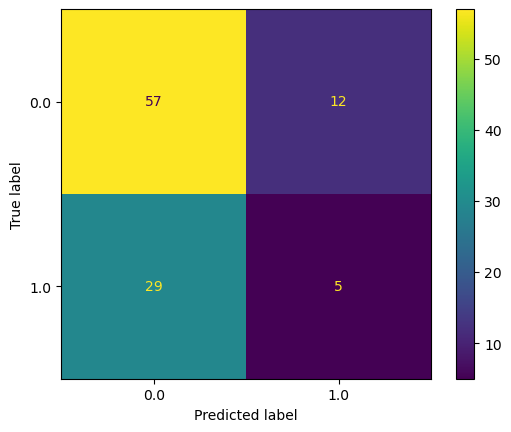

In [316]:
# Create a confusion matrix for the test set predictions.
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(target_test, test_pred);

In [317]:
# Get the precision, recall, and F1-score for the test set predictions.

print("Precision = {:.5f}".format(precision_score(target_test, test_pred)))
print("Recall = {:.5f}".format(recall_score(target_test, test_pred)))
print("F1 Score = {:.5f}".format(f1_score(target_test, test_pred)))

Precision = 0.29412
Recall = 0.14706
F1 Score = 0.19608


This initial model performs just okay but I would like to investigate removing irrelevant features for Classification. For this section,I tested the contributions of different values of k so then later, I can develop a model removing those features which have very low contributions. 


In [318]:
# feature selection - the two steps here are based off of the How to Perform Feature Selection with Categorical Data
# by Jason Brownlee

# here creating a function that is similar to selecting individual values for k 
# doing one at a time is not ideal 
# so I am using the same statistic but as part of a loop in order to see which k is the best performing 
def select_features(X_train, y_train, X_test):
    
 chifs = SelectKBest(score_func=chi2, k='all')
 chifs.fit(X_train, y_train)
 X_train_fs = chifs.transform(X_train)
 X_test_fs = chifs.transform(X_test)
    
 return X_train_fs, X_test_fs, chifs

Feature 1: 0.466080
Feature 2: 0.543438
Feature 3: 0.001025
Feature 4: 0.157734
Feature 5: 2.451456
Feature 6: 1.470874
Feature 7: 1.079273
Feature 8: 0.785508
Feature 9: 0.001794
Feature 10: 3.922330
Feature 11: 6.198276
Feature 12: 0.228415
Feature 13: 2.837262
Feature 14: 1.034616
Feature 15: 3.922330
Feature 16: 0.568120
Feature 17: 5.393204
Feature 18: 0.529895
Feature 19: 0.785508
Feature 20: 2.824430
Feature 21: 2.334820
Feature 22: 2.824430
Feature 23: 6.423363
Feature 24: 2.375320
Feature 25: 1.432295
Feature 26: 1.034616
Feature 27: 0.050264
Feature 28: 0.050264
Feature 29: 0.001025
Feature 30: nan
Feature 31: 5.893333
Feature 32: 0.034317
Feature 33: 0.151449
Feature 34: 0.571037
Feature 35: 0.150183


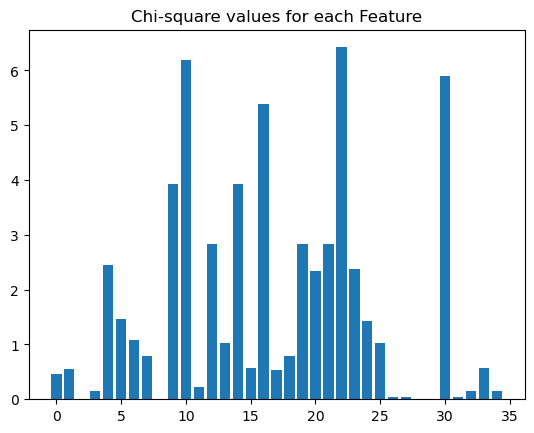

Features with chi-squares values less than 0.2
Feature 3: 0.001025
Feature 4: 0.157734
Feature 9: 0.001794
Feature 27: 0.050264
Feature 28: 0.050264
Feature 29: 0.001025
Feature 32: 0.034317
Feature 33: 0.151449
Feature 35: 0.150183


In [319]:
# listing out the chi square values and then plotting to see which is the highest - the highest is the k to move forward with 
X_train_fs, X_test_fs, chifs = select_features(features_train, target_train, features_test)
# what are scores for the features
for i in range(len(chifs.scores_)):
  print('Feature %d: %f' % (i+1, chifs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(chifs.scores_))], chifs.scores_)
plt.title("Chi-square values for each Feature")
plt.show()


print("Features with chi-squares values less than 0.2")
for i in range(len(chifs.scores_)):
  if chifs.scores_[i]< 0.2:
      
      print('Feature %d: %f' % (i+1, chifs.scores_[i]))
         


I am dropping features with values less than 0.2 and redoing this model. There are 10 features with values under 0.2 so this means that I will use k = 25 to build a new model 

In [320]:
# reducing columns to see if that yields a better model 

chi2_selector = SelectKBest(chi2, k=25)

In [321]:
features_kbest = chi2_selector.fit_transform(features_train, target_train)

In [322]:
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_kbest.shape[1])

Original number of features: 35
Reduced number of features: 25


In [323]:
from numpy import array 

filter = chi2_selector.get_support()
features20 = array(features.columns)

In [324]:
# printing the features 
print("Selected best 20:")
print(features20[filter])

Selected best 20:
['Study.2' 'SiteID.102' 'SiteID.105' 'SiteID.106' 'SiteID.107'
 'SiteID.108' 'SiteID.110' 'SiteID.111' 'SiteID.112' 'SiteID.113'
 'SiteID.114' 'SiteID.115' 'SiteID.201' 'SiteID.202' 'SiteID.203'
 'SiteID.204' 'SiteID.205' 'SiteID.206' 'SiteID.207' 'SiteID.208'
 'SiteID.209' 'SiteID.210' 'SiteID.211' 'Sex.M' 'GTCat.Low']


In [325]:
type(features20)

numpy.ndarray

In [326]:
xx = features20[filter].tolist()
xx

['Study.2',
 'SiteID.102',
 'SiteID.105',
 'SiteID.106',
 'SiteID.107',
 'SiteID.108',
 'SiteID.110',
 'SiteID.111',
 'SiteID.112',
 'SiteID.113',
 'SiteID.114',
 'SiteID.115',
 'SiteID.201',
 'SiteID.202',
 'SiteID.203',
 'SiteID.204',
 'SiteID.205',
 'SiteID.206',
 'SiteID.207',
 'SiteID.208',
 'SiteID.209',
 'SiteID.210',
 'SiteID.211',
 'Sex.M',
 'GTCat.Low']

In [327]:
features20n = features[features.columns[features.columns.isin(xx)]]
features20n

,Study.2,SiteID.102,SiteID.105,SiteID.106,SiteID.107,SiteID.108,SiteID.110,SiteID.111,SiteID.112,SiteID.113,...,SiteID.204,SiteID.205,SiteID.206,SiteID.207,SiteID.208,SiteID.209,SiteID.210,SiteID.211,Sex.M,GTCat.Low
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
424,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
425,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [352]:
# creating new split for train and test to fit new model 
features20_train, features20_test, target20_train, target20_test = \
train_test_split(features20n, target, test_size=0.5, random_state=0)

In [353]:
# fitting new model 
model20 = log_regression.fit(features20_train, target20_train)
model20

LogisticRegression(random_state=0)

In [354]:
# printing r2 value 
print(log_regression.score(features20_train, target20_train))

0.7121951219512195


In [355]:
# creating predication on test
test20_pred = log_regression.predict(features20_test)

In [356]:
# printing accuracy score of the model 
print('Accuracy = {:.5f}'.format(accuracy_score(target20_test, test20_pred)))

Accuracy = 0.59512


Confusion Matrix


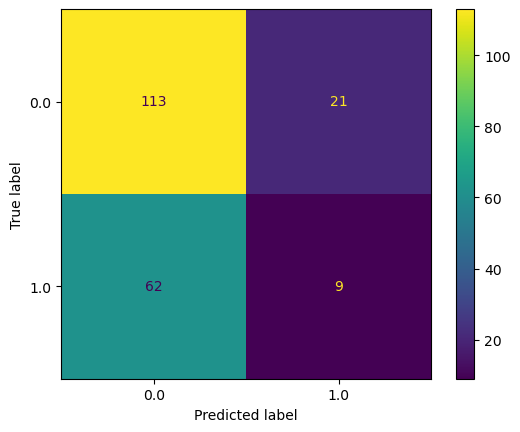

In [357]:
# Create a confusion matrix for the test set predictions.
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(target20_test, test20_pred);

Doing hyperparameterization for logistic regression - I referred work by Jason Brownlee for this section. The format is different than our homework - and I did not initially remember the issues using l1 however, l1 is not included below as it triggers errors. Because my reduced model is better in some ways than the original model, I will perform hyperparameterization on the the reduced model. 

In [358]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [359]:
# creating a dictionary of the above values 
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [360]:
# define grid search - using RepeatedStatifiedFold 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


In [361]:
# creating search with GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)


In [362]:
# fitting original data (that has been reduced)
grid_result = grid_search.fit(features20n, target)


In [363]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.670732 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.609756 (0.047961) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.609756 (0.047961) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.609756 (0.047961) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.615447 (0.051426) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.615447 (0.051426) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.615447 (0.051426) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.615447 (0.042565) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.615447 (0.042565) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.615447 (0.042565) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.670732 (0.012195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.670732 (0.012195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.670732 (0.012195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.670732 (0.012195) wit

In [364]:
# final model using parameters specified above 
flogreg = LogisticRegression(penalty='l2', C=0.1, solver='newton-cg')

In [365]:
modelf = flogreg.fit(features20_train, target20_train)
modelf

LogisticRegression(C=0.1, solver='newton-cg')

In [366]:
# r2 value
print(flogreg.score(features20_train, target20_train))

0.6878048780487804


In [367]:
# creating predictions on test
test_pred = flogreg.predict(features20_test)

In [368]:
# model accuracy 
print('Accuracy = {:.5f}'.format(accuracy_score(target20_test, test_pred)))

Accuracy = 0.65366


Confusion Matrix


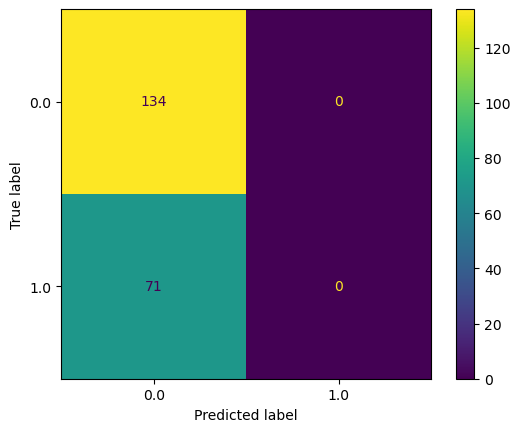

In [369]:
# Create a confusion matrix for the test set predictions.
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(target20_test, test_pred);

In [370]:
print("Classification report: ", classification_report(target20_test, test_pred))

Classification report:                precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       134
         1.0       0.00      0.00      0.00        71

    accuracy                           0.65       205
   macro avg       0.33      0.50      0.40       205
weighted avg       0.43      0.65      0.52       205



C:\Users\kkooken\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kkooken\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kkooken\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting the by REGION model now that I am done with the first model of site location 

In [379]:
# BY REGION model is second
target2 = sevmetn22_dummies["Target"]
target2

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
423    0.0
424    0.0
425    1.0
426    0.0
427    1.0
Name: Target, Length: 410, dtype: float64

In [380]:
features2 = sevmetn22_dummies.drop({"Target"}, axis=1)
features2

,Study.2,Region_MetroArea.Boston MA-Manchester NH,Region_MetroArea.British Columbia,Region_MetroArea.Chicago IL,Region_MetroArea.Denver CO,Region_MetroArea.Detroit MI,Region_MetroArea.Greensboro-High Point-Winston Salem NC,Region_MetroArea.Los Angeles CA,Region_MetroArea.Miami-Ft. Lauderdale FL,Region_MetroArea.Nashville TN,...,Region_MetroArea.Raleigh-Durham (Fayetteville) NC,Region_MetroArea.San Diego CA,Region_MetroArea.San Francisco-Oakland-San Jose CA,Region_MetroArea.Spokane WA,Region_MetroArea.Washington DC (Hagerstown MD),Sex.M,AgeCat.>40-65,AgeCat.>65,GTCat.Low,GTCat.Medium
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
424,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
425,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
426,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [381]:
# creating train and test for second model 
features2_train, features2_test, target2_train, target2_test = train_test_split(features2, target2, test_size=0.25, random_state=0)

In [382]:
# fit regression model to current data 
model = log_regression.fit(features2_train, target2_train)

In [383]:
# print the r2 value 
print(log_regression.score(features2_train, target2_train))

0.6872964169381107


In [384]:
# make predictions on test
test_pred2 = log_regression.predict(features2_test)

In [385]:
# print the accuracy of the model 
print('Accuracy = {:.5f}'.format(accuracy_score(target2_test, test_pred2)))

Accuracy = 0.66990


Confusion Matrix


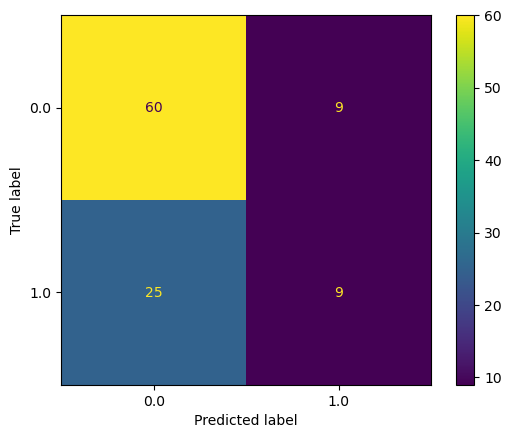

In [386]:
# Create a confusion matrix for the test set predictions.
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(target2_test, test_pred2);

In [387]:
print("Classification report: ", classification_report(target2_test, test_pred2))

Classification report:                precision    recall  f1-score   support

         0.0       0.71      0.87      0.78        69
         1.0       0.50      0.26      0.35        34

    accuracy                           0.67       103
   macro avg       0.60      0.57      0.56       103
weighted avg       0.64      0.67      0.64       103



Feature 1: 0.466080
Feature 2: 0.157734
Feature 3: 2.914424
Feature 4: 5.393204
Feature 5: 0.543438
Feature 6: 3.922330
Feature 7: 2.824430
Feature 8: 0.385815
Feature 9: 1.166070
Feature 10: 6.118812
Feature 11: 6.423363
Feature 12: 9.941217
Feature 13: 1.034616
Feature 14: 0.930650
Feature 15: 0.001025
Feature 16: 0.001025
Feature 17: 0.050264
Feature 18: 0.785508
Feature 19: nan
Feature 20: 0.529895
Feature 21: 5.893333
Feature 22: 0.034317
Feature 23: 0.151449
Feature 24: 0.571037
Feature 25: 0.150183


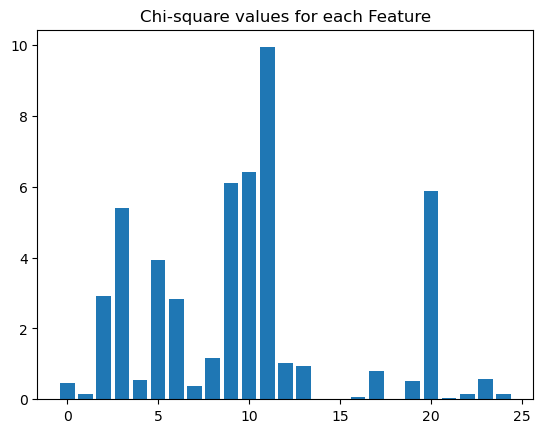

Features with chi-squares values less than 0.2
Feature 2: 0.157734
Feature 15: 0.001025
Feature 16: 0.001025
Feature 17: 0.050264
Feature 22: 0.034317
Feature 23: 0.151449
Feature 25: 0.150183


In [388]:
# same as above - investigating the possibility to drop some features that are not relevant 

X_train_fs, X_test_fs, chifs = select_features(features2_train, target2_train, features2_test)
# what are scores for the features
for i in range(len(chifs.scores_)):
  print('Feature %d: %f' % (i+1, chifs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(chifs.scores_))], chifs.scores_)
plt.title("Chi-square values for each Feature")
plt.show()


print("Features with chi-squares values less than 0.2")
for i in range(len(chifs.scores_)):
  if chifs.scores_[i]< 0.2:
      
      print('Feature %d: %f' % (i+1, chifs.scores_[i]))
         

In [389]:
# 25 - 7 = 18
# reducing columns to see if that yields a better model 

chi2_selector = SelectKBest(chi2, k=18)

In [390]:
features_kbest = chi2_selector.fit_transform(features2_train, target2_train)

In [391]:
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_kbest.shape[1])

Original number of features: 35
Reduced number of features: 18


In [394]:
from numpy import array 

filter = chi2_selector.get_support()
features2_ = array(features2.columns)

In [395]:
# printing the features 
print("Selected best 20:")
print(features2_[filter])

Selected best 20:
['Study.2' 'Region_MetroArea.Boston MA-Manchester NH'
 'Region_MetroArea.British Columbia' 'Region_MetroArea.Chicago IL'
 'Region_MetroArea.Denver CO' 'Region_MetroArea.Detroit MI'
 'Region_MetroArea.Greensboro-High Point-Winston Salem NC'
 'Region_MetroArea.Los Angeles CA'
 'Region_MetroArea.Miami-Ft. Lauderdale FL'
 'Region_MetroArea.Nashville TN' 'Region_MetroArea.New Orleans LA'
 'Region_MetroArea.New York NY' 'Region_MetroArea.Omaha NE'
 'Region_MetroArea.Ontario'
 'Region_MetroArea.San Francisco-Oakland-San Jose CA'
 'Region_MetroArea.Washington DC (Hagerstown MD)' 'Sex.M' 'GTCat.Low']


In [396]:
type(features2_)

numpy.ndarray

In [397]:
xx = features2_[filter].tolist()
xx

['Study.2',
 'Region_MetroArea.Boston MA-Manchester NH',
 'Region_MetroArea.British Columbia',
 'Region_MetroArea.Chicago IL',
 'Region_MetroArea.Denver CO',
 'Region_MetroArea.Detroit MI',
 'Region_MetroArea.Greensboro-High Point-Winston Salem NC',
 'Region_MetroArea.Los Angeles CA',
 'Region_MetroArea.Miami-Ft. Lauderdale FL',
 'Region_MetroArea.Nashville TN',
 'Region_MetroArea.New Orleans LA',
 'Region_MetroArea.New York NY',
 'Region_MetroArea.Omaha NE',
 'Region_MetroArea.Ontario',
 'Region_MetroArea.San Francisco-Oakland-San Jose CA',
 'Region_MetroArea.Washington DC (Hagerstown MD)',
 'Sex.M',
 'GTCat.Low']

In [398]:
features2n = features2[features2.columns[features2.columns.isin(xx)]]
features2n

,Study.2,Region_MetroArea.Boston MA-Manchester NH,Region_MetroArea.British Columbia,Region_MetroArea.Chicago IL,Region_MetroArea.Denver CO,Region_MetroArea.Detroit MI,Region_MetroArea.Greensboro-High Point-Winston Salem NC,Region_MetroArea.Los Angeles CA,Region_MetroArea.Miami-Ft. Lauderdale FL,Region_MetroArea.Nashville TN,Region_MetroArea.New Orleans LA,Region_MetroArea.New York NY,Region_MetroArea.Omaha NE,Region_MetroArea.Ontario,Region_MetroArea.San Francisco-Oakland-San Jose CA,Region_MetroArea.Washington DC (Hagerstown MD),Sex.M,GTCat.Low
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
424,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
425,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
426,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [399]:
# creating new split for train and test to fit new model 
features2__train, features2__test, target2__train, target2__test = \
train_test_split(features2n, target, test_size=0.5, random_state=0)

In [400]:
# fit regression model to current data 
model = log_regression.fit(features2__train, target2__train)

In [401]:
# print the r2 value 
print(log_regression.score(features2__train, target2__train))

0.7073170731707317


In [402]:
# make predictions on test
test__pred2 = log_regression.predict(features2__test)

In [403]:
# print the accuracy of the model 
print('Accuracy = {:.5f}'.format(accuracy_score(target2__test, test__pred2)))

Accuracy = 0.65366


Confusion Matrix


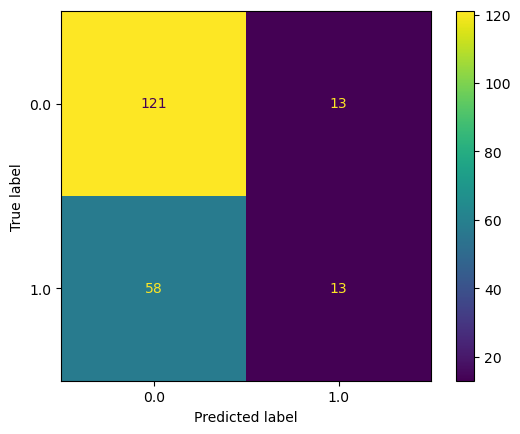

In [404]:
# Create a confusion matrix for the test set predictions.
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(target2__test, test__pred2);

Doing hyperparameterization for logistic regression - I referred work by Jason Brownlee again for this section. Because my reduced model is better in some ways than the original model, I will perform hyperparameterization on the the reduced model. 

In [405]:
# fitting original data (that has been reduced)
grid_result = grid_search.fit(features2n, target)

In [406]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.676423 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.659350 (0.050570) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.659350 (0.050570) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.659350 (0.050570) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.660976 (0.050518) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.660976 (0.050518) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.660976 (0.050518) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.676423 (0.036140) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.676423 (0.036140) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.676423 (0.036140) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.670732 (0.012195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.670732 (0.012195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.673171 (0.014903) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.670732 (0.012195) wit

In [409]:
# final model using parameters specified above 
flogreg2 = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg')

In [410]:
modelf = flogreg2.fit(features2__train, target2__train)
modelf

LogisticRegression(solver='newton-cg')

In [411]:
# r2 value
print(flogreg2.score(features2__train, target2__train))

0.7073170731707317


In [412]:
# creating predictions on test
test2_pred = flogreg2.predict(features2__test)

In [413]:
# print the accuracy of the model 
print('Accuracy = {:.5f}'.format(accuracy_score(target2__test, test2_pred)))

Accuracy = 0.65366


Confusion Matrix


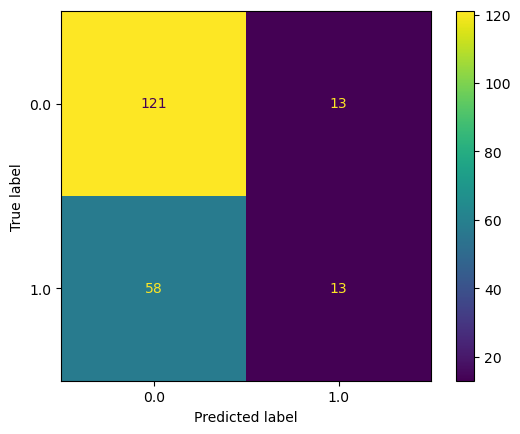

In [415]:
# Create a confusion matrix for the test set predictions.
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(target2__test, test2_pred);

Write-up for Project 4: 

For my model - I used a logistic regression model on two sets of data where the difference between the two was site location or metro location. I choose this model because I had a categorical dependent variable as well as I created categorical variables of all my features. Logistic regression seemed like the best model choice because I am looking to predict which locations produce the best outcomes. Likewise, I focused my model evaluation by reviewing the r-squared value as well as the accuracy scores and created confusion matrix for each model. I thought these key evaluations worked well to compare the different models to eachother. Results from this analysis are displayed below. 

#### <center> Results summarized from logistic regression model

Model 1 (by SITE)| Intial       | Reduced   | Reduced Hyper |
-----------------|--------------|-----------|---------------|
R-squared        | 0.69         | 0.71      | **0.69**      |
Accuracy         | 0.60         | 0.60      | **0.65**      |


Model 2 (by REGION| Intial       | Reduced   | Reduced Hyper |
------------------|--------------|-----------|---------------|
R-squared         | 0.69         | **0.71**  | **0.71**      |
Accuracy          | 0.67         | **0.65**  | **0.65**      |
    

For this modeling effort, I think that for both Model 1 and Model 2 the last model run, which had parameter reducation as well as hyperparameterization done, performed the best. Though the r-squared is lower for the first model the accuracy score is higher and I determined this to be a stronger model. The better results are bolded in the tables above.  
    
That said, I was had hoped that my models would have performed better and I am still thinking about how I might approach this problem to develop a stronger model.